In [1]:
# set width = 95%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# heatmaps with color *and* marker size, useful for correlation plots
!{sys.executable} -m pip install heatmapz -q
from heatmap import heatmap, corrplot

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, **kwargs):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
    if tight_layout==True:
        plt.tight_layout()
    elif tight_layout==False:
        pass
    else:
        plt.tight_layout(pad=tight_layout)
    plt.savefig(path, format=fig_extension, dpi=resolution,**kwargs)

In [3]:
# Plotting Functions

# function to create line plots from a dataframe
# plots data in one column split across categories in another
#    x_col: x-data column name
#    x_col: y-data column name (iterates over list)
#    split_col: column name, column containing up to 5 unique values for splitting rows
#    plot_mean: if true, plot the mean for each split and include the value in the legend
#    vert_line: x-value of vertical line to plot
# todos:
#    enable single y_cols
#    allow set of multiple boolean columns in split_col
#    allow np-arrays x_col
#    allow boolean or categorical array for split_col
#    allow multiple vert_lines
def split_line_plot(df,x_col,y_cols,split_col,plot_mean = False, vert_line = None):
    # solid, dashed, dotted, dash-dotted, dash-dot-dotted
    split_styles = ['-','--',':','-.', (0, (3, 5, 1, 5, 1, 5))]
    split_vals = df[split_col].unique()
    n_splits = len(split_vals)
    if n_splits > 5:
        raise ValueError("Too many categories to plot")
    fig, axs = plt.subplots(len(y_cols),figsize=(12,8*len(y_cols)))
    for ind_col in range(0,len(y_cols)):
        for ind_split in range(0,n_splits):
            split_val = split_vals[ind_split]
            if plot_mean:
                split_mean = df.loc[df[split_col]==split_val,y_cols[ind_col]].agg('mean')
                df[df[split_col]==split_val].plot(
                    kind='line',x=x_col,y=y_cols[ind_col],ax=axs[ind_col],
                    label="{:s}: {:} (mean: {:#0.2g})".format(col_alias[split_col],split_val,split_mean),
                    style=split_styles[ind_split],color="C{}".format(ind_split))
                axs[ind_col].axhline(split_mean, color="C{}".format(ind_split),
                    label="_{:s}: {:} mean: {:#0.2g}".format(col_alias[split_col],split_val,split_mean) )
            else:
                df[df[split_col]==split_val].plot(
                    kind='line',x=x_col,y=y_cols[ind_col],ax=axs[ind_col],
                    label="{:s}: {:}".format(col_alias[split_col],split_val),
                    style=split_styles[ind_split],color="C{}".format(ind_split))
        if vert_line != None:
            axs[ind_col].axvline(vert_line,color='k',linestyle='-',linewidth=2)
        
        axs[ind_col].set_ylabel(col_alias[y_cols[ind_col]])
        axs[ind_col].legend()
        if ind_col==len(y_cols)-1:
            axs[ind_col].set_xlabel(col_alias[x_col])
        else:
            axs[ind_col].set_xlabel('')

# Get the data

## Description from Kaggle
### Plant_<1,2>_Generation_Data.csv
Solar power generation data for one plant gathered at 15 minutes intervals over a 34 days period.

**DATE_TIME**
Date and time for each observation. Observations recorded at 15 minute intervals.

**PLANT_ID**
Plant ID - this will be common for the entire file.

**SOURCE_KEY**
Source key in this file stands for the inverter id.

**DC_POWER**
Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

**AC_POWER**
Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

**DAILY_YIELD**
Daily yield is a cumulative sum of power generated on that day, till that point in time.

**TOTAL_YIELD**
This is the total yield for the inverter till that point in time.

### Plant_<1,2>_Weather_Sensor_Data.csv
Weather sensor data gathered for one solar plant every 15 minutes over a 34 days period.

**DATE_TIME**
Date and time for each observation. Observations recorded at 15 minute intervals.

**PLANT_ID**
Plant ID - this will be common for the entire file.

**SOURCE_KEY**
Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant.

**AMBIENT_TEMPERATURE**
This is the ambient temperature at the plant.

**MODULE_TEMPERATURE**
There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.

**IRRADIATION**
Amount of irradiation for the 15 minute interval.

In [4]:
DATA_PATH = PROJECT_ROOT_DIR + "/Data Files"

def load_power_data(plant_num = 1,power_path=DATA_PATH,plant_tot=False):
    if isinstance(plant_num, list):
        dfs = []
        for plant_ind in plant_num:
            dfs.append(load_power_data(plant_ind,power_path,plant_tot))
        return pd.concat(dfs)
    csv_path = os.path.join(power_path, "Plant_{:d}_Generation_Data.csv".format(plant_num))
    df = pd.read_csv(csv_path)
    df["PLANT_ID"] = plant_num
    try:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%d-%m-%Y %H:%M")
    except: 
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%Y-%m-%d %H:%M:%S")
    if plant_tot:
        df = df.groupby(['DATE_TIME','PLANT_ID']).agg('sum').reset_index()
    else:
        # map inverter codes --> numbers (*not* distinct for different plants)
        # stability extension: hard-code map to ensure consistency across data sets
        df['inverter #']=df['SOURCE_KEY'].factorize()[0]+1
        df.drop("SOURCE_KEY",axis=1, inplace=True)
#     df.set_index('DATE_TIME', inplace=True)
    return df

def load_weather_data(plant_num = 1,weather_path=DATA_PATH):
    if isinstance(plant_num, list):
        dfs = []
        for plant_ind in plant_num:
            dfs.append(load_weather_data(plant_ind,weather_path))
        return pd.concat(dfs)
    csv_path = os.path.join(weather_path, "Plant_{:d}_Weather_Sensor_Data.csv".format(plant_num))
    df = pd.read_csv(csv_path)
    df["PLANT_ID"] = plant_num
    try:
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%d-%m-%Y %H:%M")
    except: 
        df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'],format="%Y-%m-%d %H:%M:%S")
    df.drop("SOURCE_KEY",axis=1, inplace=True)
#     df.set_index('DATE_TIME', inplace=True)
    return df

def load_power_and_weather_data(plant_num = 1,weather_path=DATA_PATH,power_path=DATA_PATH,plant_tot=False):
    weather = load_weather_data(plant_num,weather_path)
    power = load_power_data(plant_num,power_path,plant_tot)
    return power.merge(weather,how='outer',on=['PLANT_ID','DATE_TIME'])

# define aliases for more readable plot labels 
col_alias = {'DATE_TIME':'time (15min interval)', 'PLANT_ID':'plant #', 'inverter #':'inverter #',
             'DC_POWER':'DC power (kW)', 'AC_POWER':'AC power (kW)',
             'DAILY_YIELD':"cumulative day's yield", 'TOTAL_YIELD':'cumulative yield',
             'AMBIENT_TEMPERATURE':'ambient temperature ($\\degree C$)',
             'MODULE_TEMPERATURE':'panel temperature ($\\degree C$)', 'IRRADIATION':'irradiation'}

In [5]:
power = load_power_data([1,2])
# power.head()
power_plant = load_power_data([1,2],plant_tot=True)
# power_plant.head()
weather = load_weather_data([1,2])
# weather.head()

In [6]:
solar = load_power_and_weather_data([1,2])
solar.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,inverter #,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,1,0.0,0.0,0.0,6259559.0,1.0,25.184316,22.857507,0.0
1,2020-05-15,1,0.0,0.0,0.0,6183645.0,2.0,25.184316,22.857507,0.0
2,2020-05-15,1,0.0,0.0,0.0,6987759.0,3.0,25.184316,22.857507,0.0
3,2020-05-15,1,0.0,0.0,0.0,7602960.0,4.0,25.184316,22.857507,0.0
4,2020-05-15,1,0.0,0.0,0.0,7158964.0,5.0,25.184316,22.857507,0.0


In [7]:
solar_plant = load_power_and_weather_data([1,2],plant_tot=True)
solar_plant.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1,0.0,0.0,0.0,143581676.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,1,0.0,0.0,0.0,143581676.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,1,0.0,0.0,0.0,143581676.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,1,0.0,0.0,0.0,143581676.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,1,0.0,0.0,0.0,150761642.0,24.621525,22.165423,0.0


In [17]:
# rows with missing data in outer join. 
# Note: power and weather have no null values
solar[solar.isnull().any(1)].head(6)

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,inverter #,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
38544,2020-06-03 14:00:00,1,7003.0,685.8,5601.0,6330385.0,2.0,NaN,NaN,NaN
38545,2020-06-03 14:00:00,1,7204.0,705.4,5685.0,6419961.0,10.0,NaN,NaN,NaN
38546,2020-06-03 14:00:00,1,7545.0,738.7,5579.0,6928448.0,18.0,NaN,NaN,NaN
38547,2020-06-03 14:00:00,1,7946.0,777.8,5541.0,7152815.0,19.0,NaN,NaN,NaN
136476,2020-05-20 23:00:00,1,NaN,NaN,NaN,NaN,NaN,23.830852,21.024118,0.0
136477,2020-05-20 23:15:00,1,NaN,NaN,NaN,NaN,NaN,23.701162,20.786399,0.0


## Observations & Notes
- What's up with cumulative yield?
- Weather at the two plants is fairly similar
    - Plant #2 is ~2.5 degree warmer
    - Very similar irradiation
- Power more different
    - Plant #2 generates little DC power, and ~15% less AC power
- Correlations:
    - total yield: higher for plant 2
    - DC power: higher for plant 1
    - DC power, AC power, module temperature, irradiation, ambient temperature strongly corellated
      (ambient slightly less than others)
    - ambient temperature peaks a few hours after noon
    - other data peaks close to noon
    - irradiation and AC/DC power generation nearly symmetric over noon
    - Plant 2 power seems to saturate at certain values: AC ~14k and DC ~2k
- TODO
    - check for missing times during night
    - investigate missing power-weather pairs
    - investigate Plant 2 power saturation
    - plot averages by day
    - plot comparison for different inverters
    - histogram to identify performance outliers
    - split_scatter?
    - possible features to add:
        - AC:DC ratio
        - module temp > ??
        - yield < ??
        - median yield by Plant, inverter
        - median temperature and irradiation by plant + time
        - before/after noon bool
        - variance of grouped data

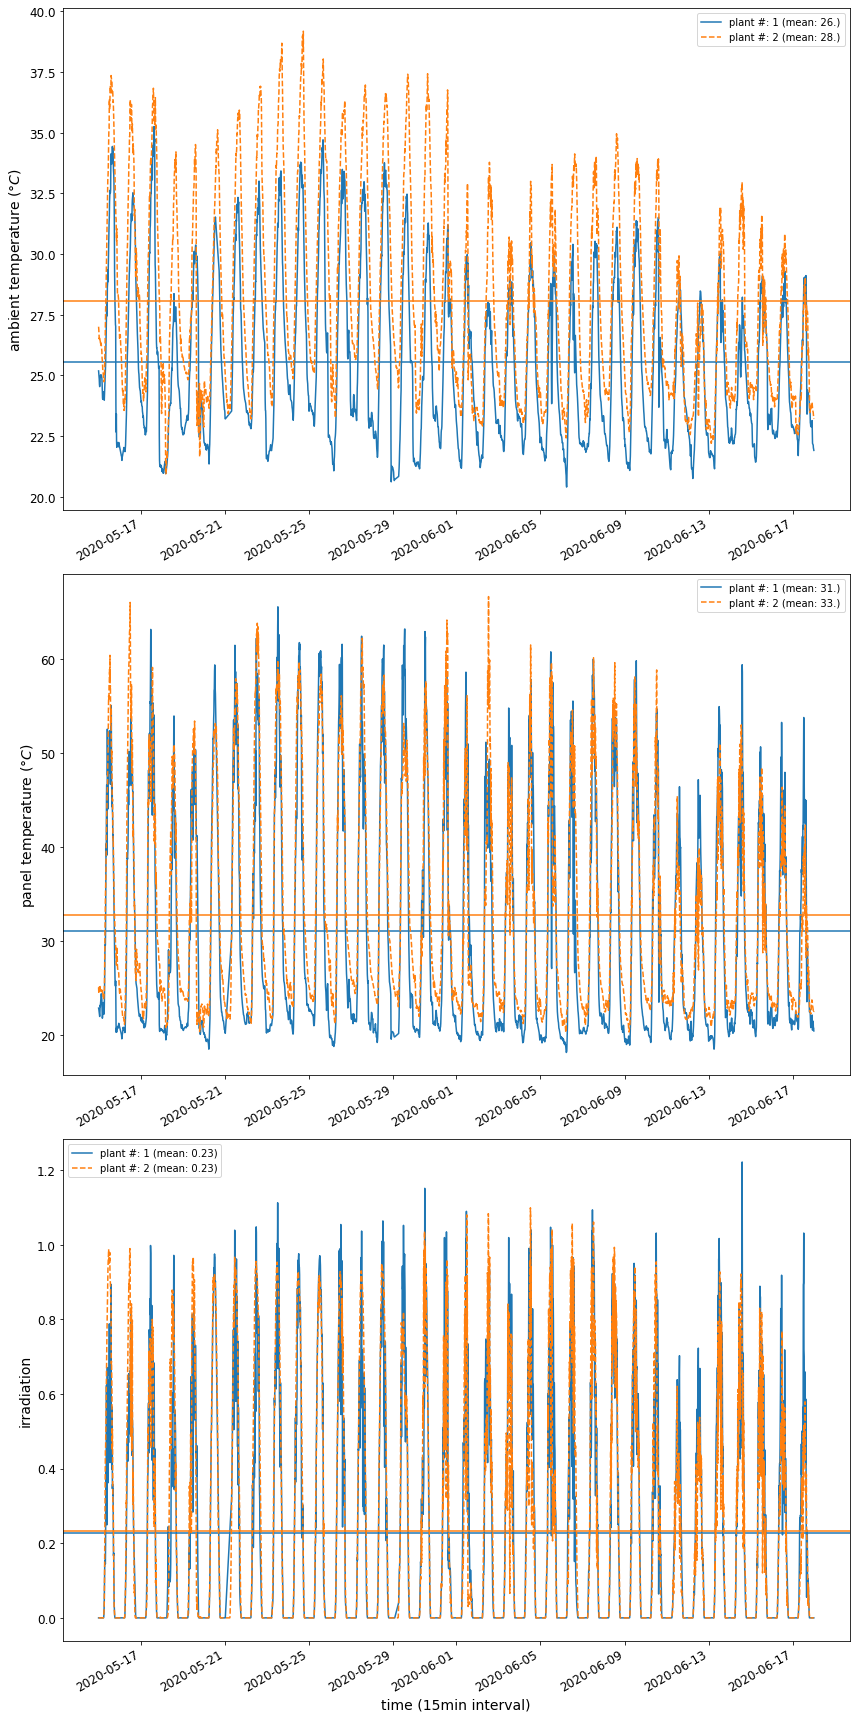

In [9]:
# compare weather data for the plants
cols = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION']
split_line_plot(weather,x_col="DATE_TIME",y_cols=cols,split_col="PLANT_ID",plot_mean=True)
save_fig("Weather vs time by plant")

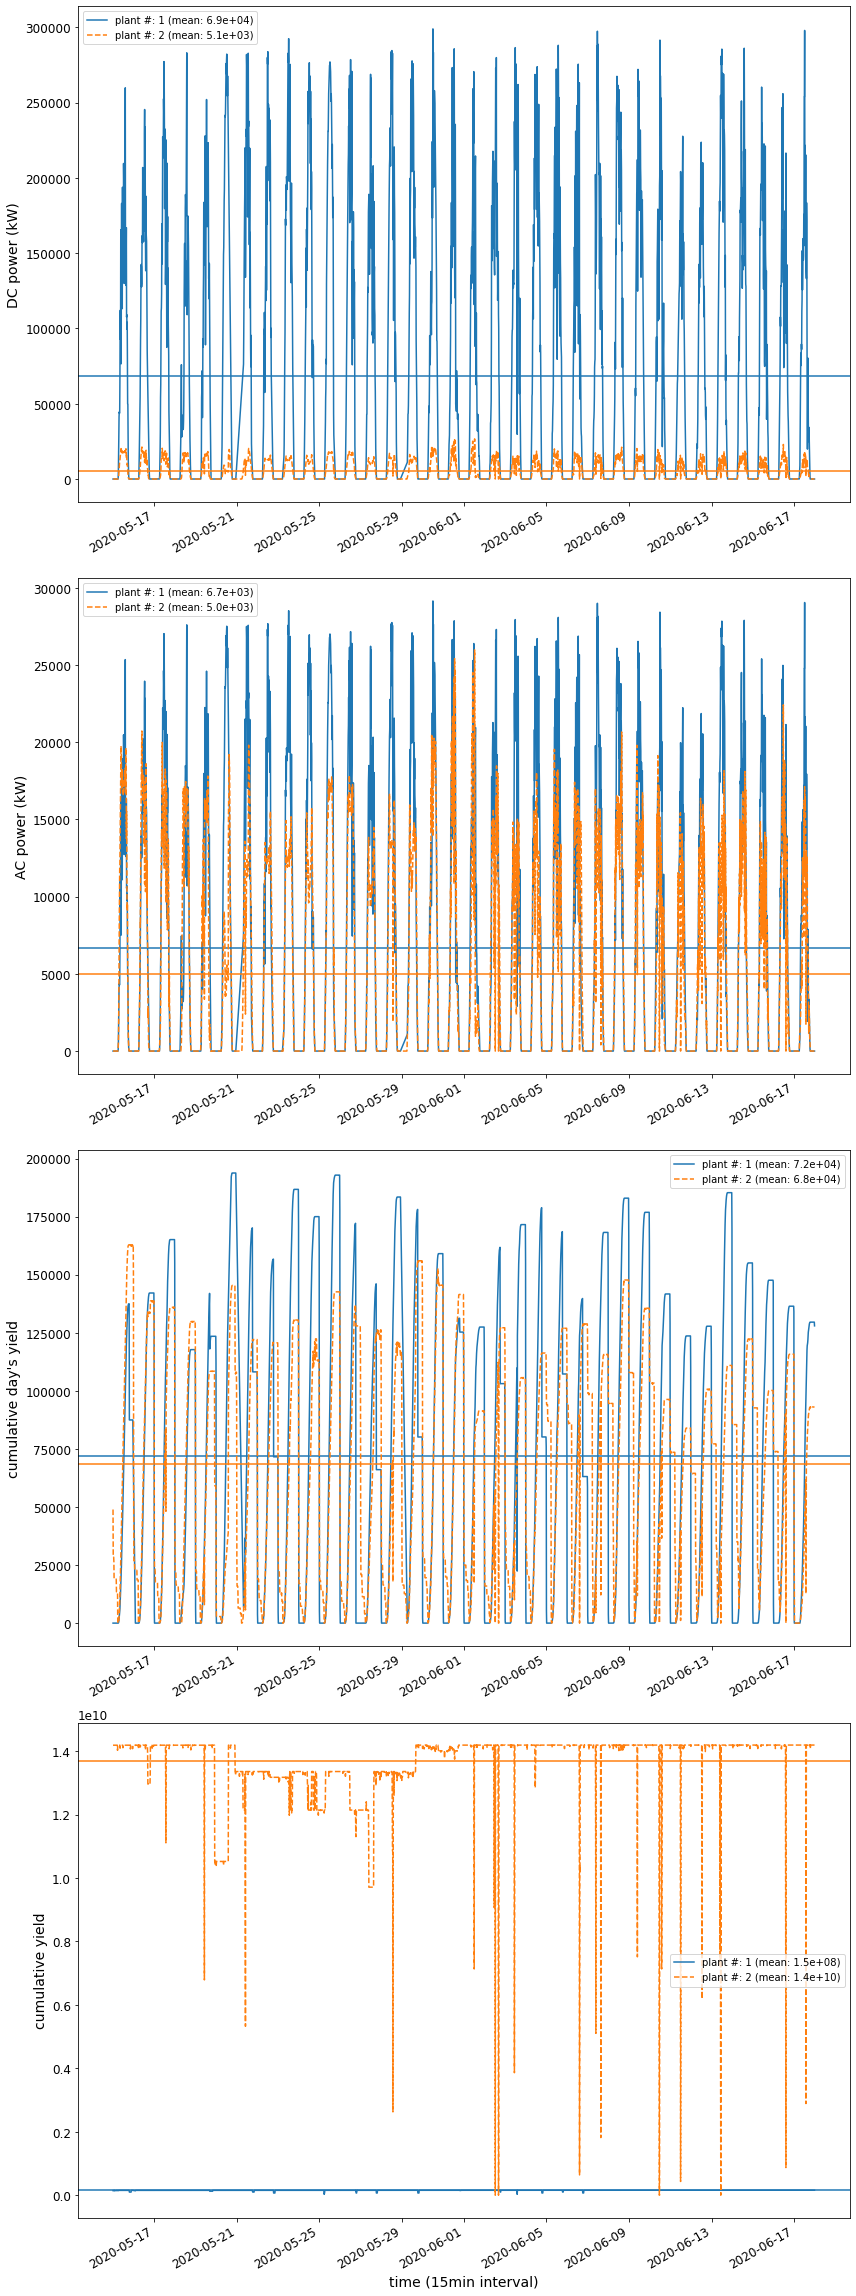

In [10]:
# compare (total) power data for the plants
cols = ['DC_POWER', 'AC_POWER','DAILY_YIELD', 'TOTAL_YIELD']
split_line_plot(power_plant,x_col="DATE_TIME",y_cols=cols,split_col="PLANT_ID",plot_mean=True)
save_fig("Power vs time by plant")

In [11]:
solar_plant["HOUR_OF_DAY"] = solar_plant["DATE_TIME"].dt.hour + solar_plant["DATE_TIME"].dt.minute/60
solar_plant["HOUR_OFF_NOON"] = np.abs(solar_plant["HOUR_OF_DAY"] - 12)
solar_by_time = solar_plant.groupby(['HOUR_OF_DAY','PLANT_ID']).agg('mean').reset_index()
col_alias['HOUR_OF_DAY'] = 'time of day'
col_alias['HOUR_OFF_NOON'] = 'hours from noon'
# solar_by_time

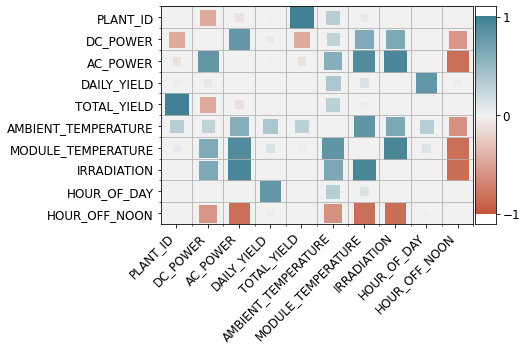

In [12]:
corrs = solar_plant.corr()
# hide distracting diagonals
np.fill_diagonal(corrs.values, np.nan)
corrplot(corrs)
save_fig("correlation_plots",tight_layout=False,bbox_inches='tight')
# note: correlation values range -0.85 - 0.99
# corrs

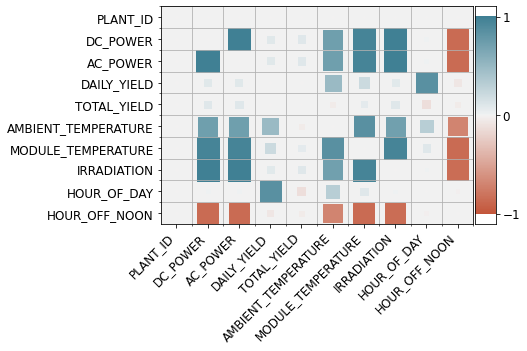

In [13]:
corrs_p1 = solar_plant.loc[solar_plant["PLANT_ID"]==1,:].corr()
np.fill_diagonal(corrs_p1.values, np.nan)
corrplot(corrs_p1)
save_fig("correlation_plots_Plant_1",tight_layout=False,bbox_inches='tight')

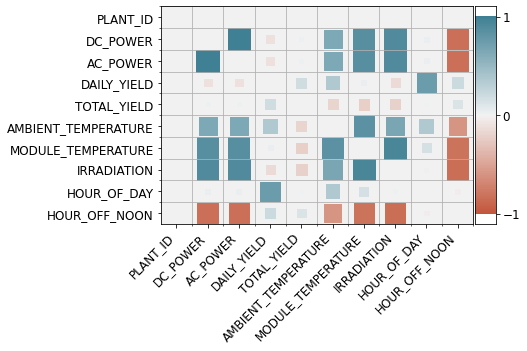

In [14]:
corrs_p2 = solar_plant.loc[solar_plant["PLANT_ID"]==2,:].corr()
np.fill_diagonal(corrs_p2.values, np.nan)
corrplot(corrs_p2)
save_fig("correlation_plots_Plant_2",tight_layout=False,bbox_inches='tight')
# note: differences from Plant 1 seem insignificant.
# side-by-side plotting complicated by use of subplots inside corrplot

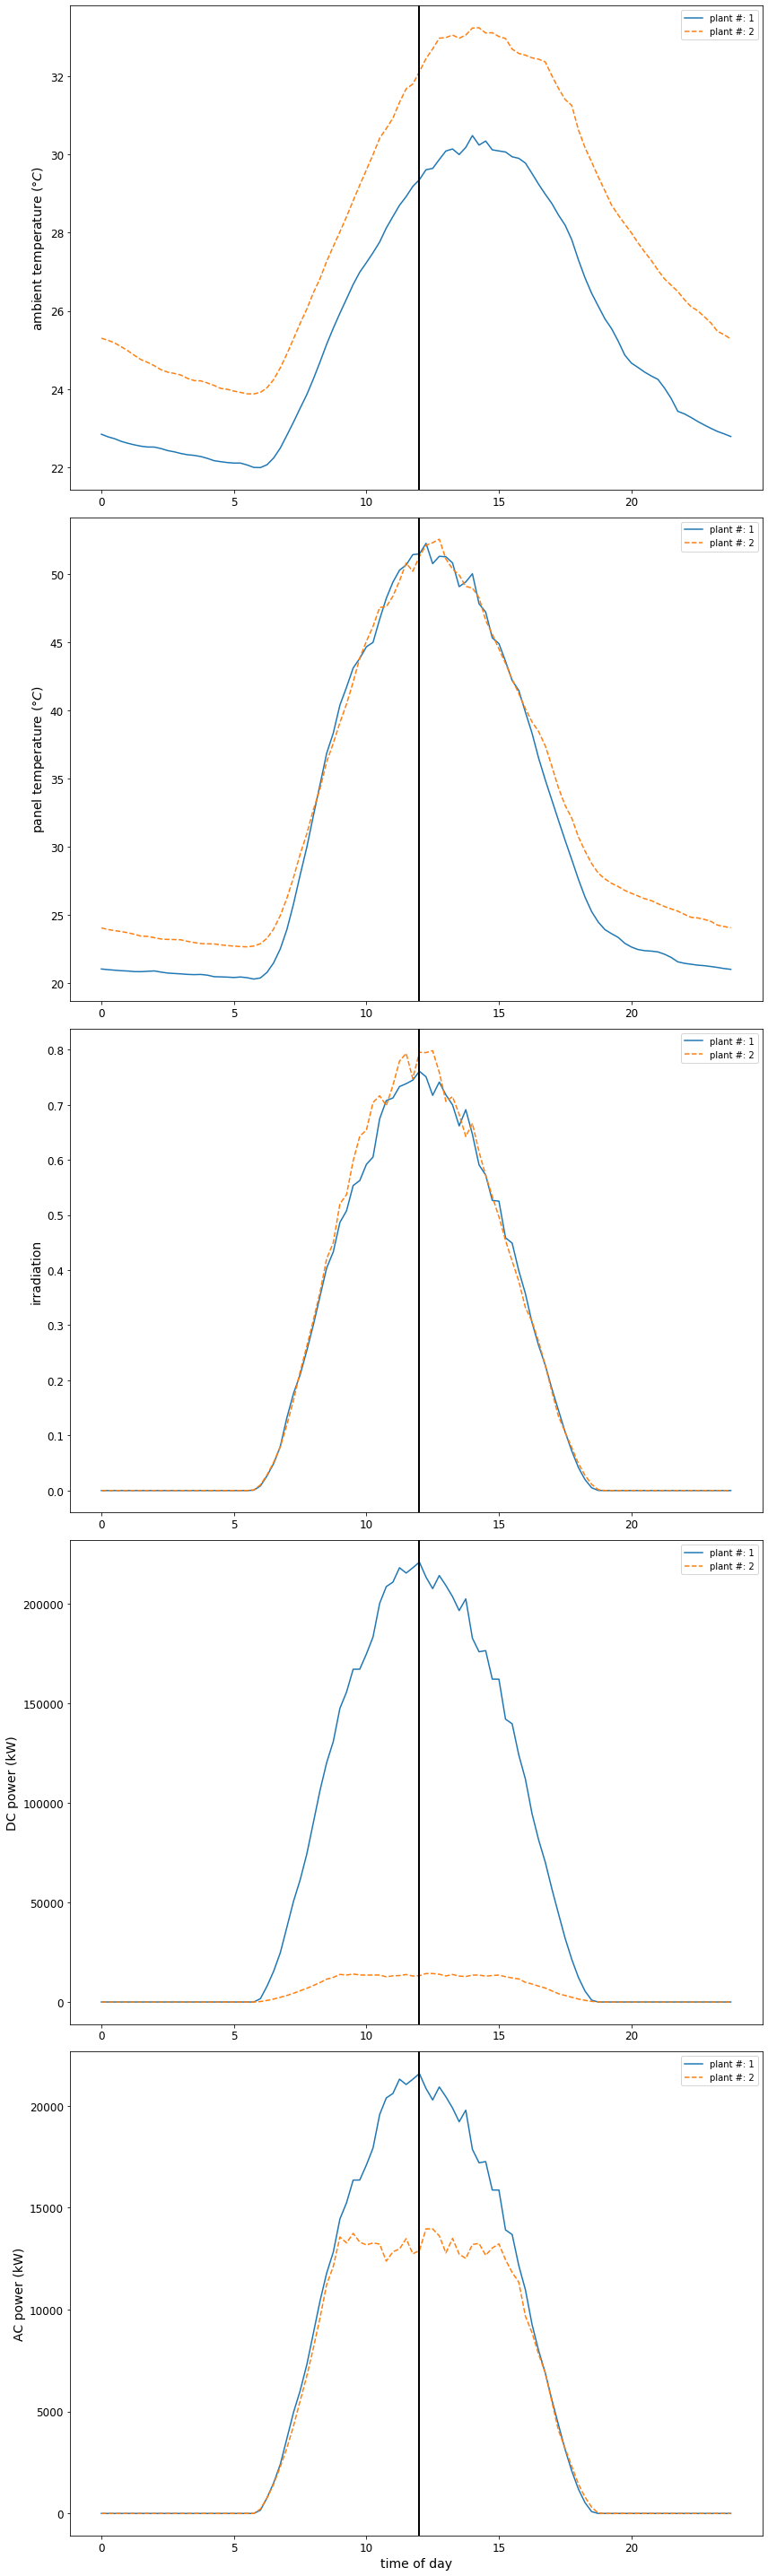

In [15]:
# compare weather & power data for the plants, by time of day
cols = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION','DC_POWER', 'AC_POWER']
split_line_plot(solar_by_time,x_col="HOUR_OF_DAY",y_cols=cols,split_col="PLANT_ID",vert_line=12)
save_fig("Solar vs time-of-day by plant")

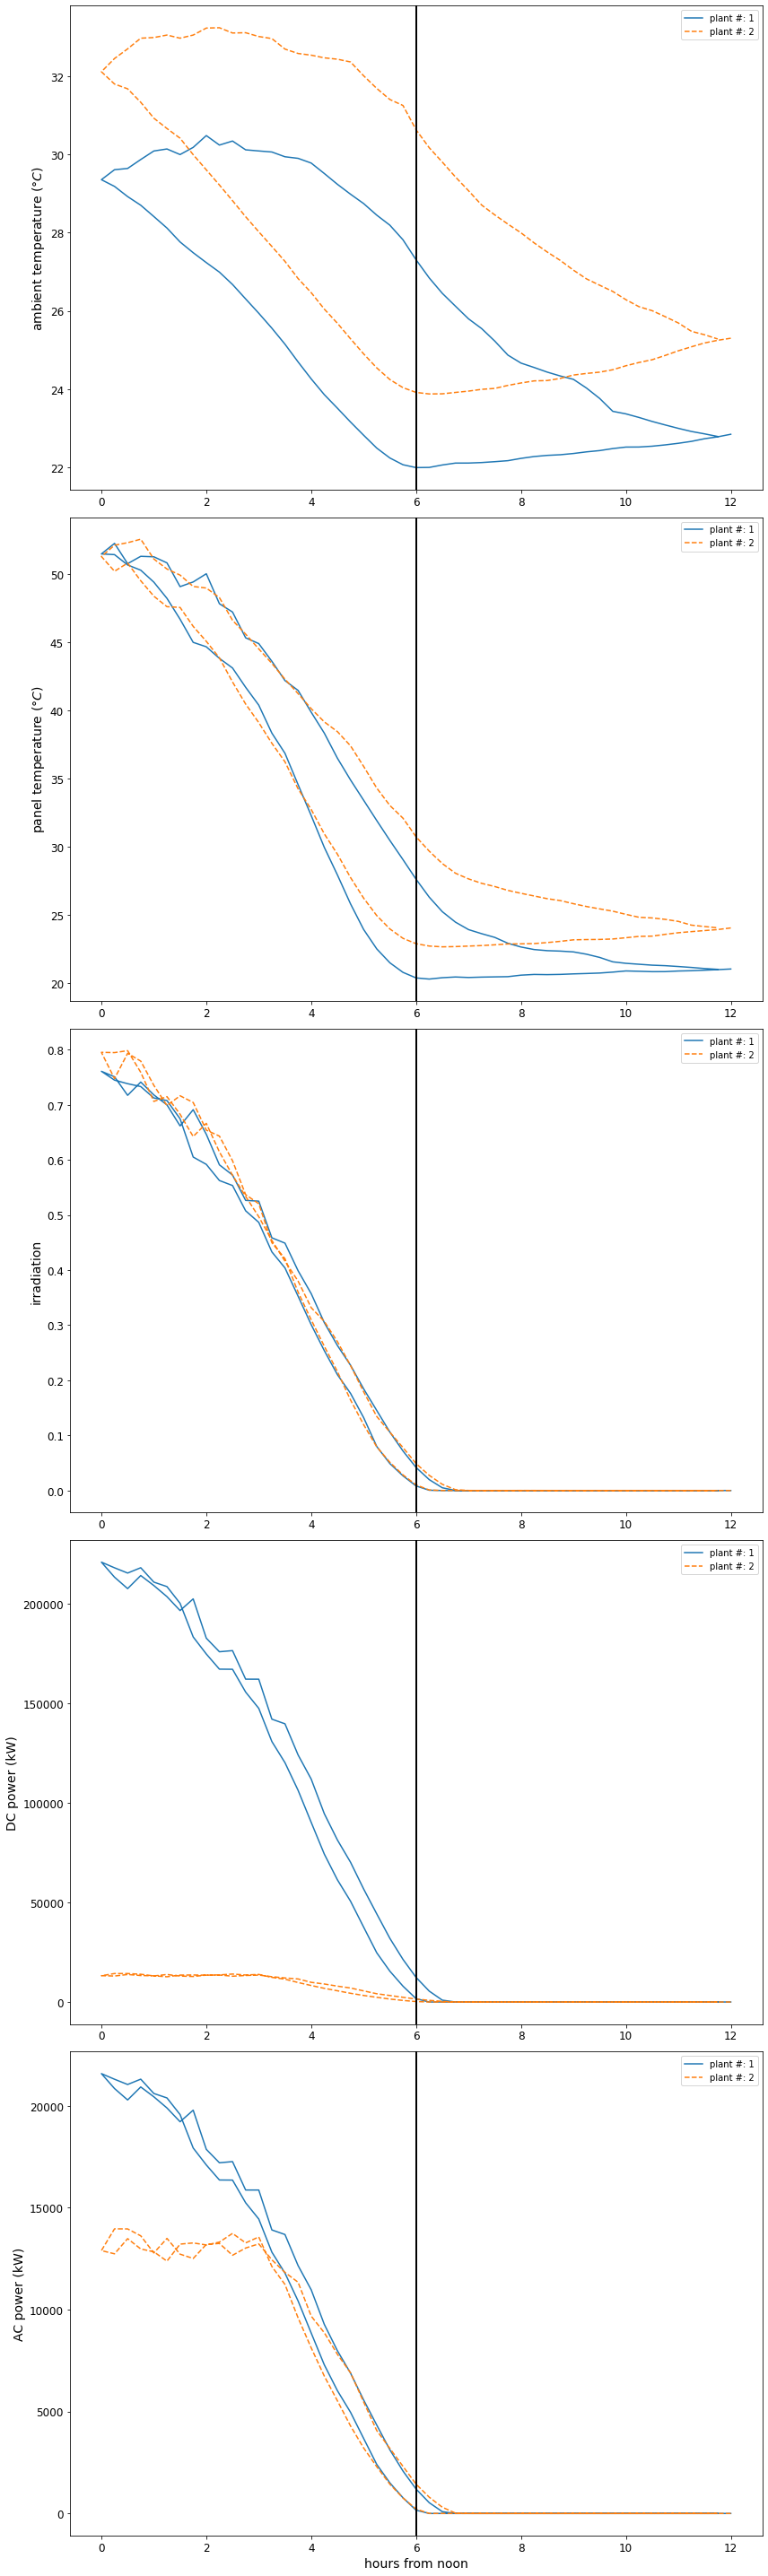

In [16]:
# compare weather & power data for the plants, by time off noon
cols = ['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION','DC_POWER', 'AC_POWER']
split_line_plot(solar_by_time,x_col="HOUR_OFF_NOON",y_cols=cols,split_col="PLANT_ID",vert_line=6)
save_fig("Solar vs time-off-noon by plant")